In [28]:
import pandas as pd
from sympy.printing.tensorflow import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor

Data Preparation

In [3]:
# Define the URL from which to fetch the CSV data.
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7BikeSharing.csv'

# Use pandas to read the CSV data from the specified URL and store it in a DataFrame 'df'.
df = pd.read_csv(url)
# Display the first 10 rows of the DataFrame 'df'.
#df = pd.read_csv('Exercise7BikeSharing.csv')
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [64]:
target = 'cnt'
features = [
    'temp', 'atemp', 'hum', 'windspeed', 'weathersit',
    'hr', 'weekday', 'workingday', 'holiday', 'season'
]

# --- Feature Engineering: Add interaction features ---
# 1. Create new columns in the DataFrame for the interaction features.
df['hr_workingday_interaction'] = df['hr'] * df['workingday']
df['weather_hum_interaction'] = df['weathersit'] * df['hum']

# 2. Add the names of the new features to your features list.
# This is a crucial step to ensure they are included in the model training.
features.append('hr_workingday_interaction')
features.append('weather_hum_interaction')

# Now, create X and y with the newly expanded feature set.
X = df[features].copy()
y = df[target].astype(float)


# Train/test split (this part remains the same)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for NN) (this part remains the same)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr) #,squared=False
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print({"LR_MSE": mse_lr, "LR_MAE": mae_lr, "LR_R2": r2_lr})

{'LR_MSE': 20707.869688812185, 'LR_MAE': 106.69134447648158, 'LR_R2': 0.34604134875169}


In [69]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


def construct_network_model(layer_sizes, dropout_rate, input_dim, learning_rate):
    """
    Function to create and compile a Keras model using a more robust structure.
    """
    model = Sequential()
    
    # Use a standalone Input layer for clarity.
    model.add(Input(shape=(input_dim,)))
    
    # Use a single, unified loop to create all hidden layers.
    for size in layer_sizes:
        model.add(Dense(size, activation='relu'))
        # Apply Dropout consistently after each hidden layer (if rate > 0).
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
            
    # Add the output layer for regression.
    model.add(Dense(1))
    
    # Compile the model.
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='mae',
                  metrics=['mae'])
    
    return model

In [77]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# Assuming you have defined KerasRegressor, construct_network_model,
# X_train_scaled, and y_train elsewhere in your code.

# --- Your Original Code ---

# Define the model using KerasRegressor wrapper
model = KerasRegressor(model=construct_network_model, verbose=0, model__input_dim=X_train_scaled.shape[1])

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Define the parameter grid for the search
param_grid = {
    "model__layer_sizes": [
        [128, 64, 32],
        [64, 32],
        [64, 64],
        [128, 128, 64],
        [256, 128, 64]
    ],
    "model__dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [32, 64],
    "model__learning_rate": [0.001, 0.01, 0.1],
    "epochs": [200]
}

# Instantiate GridSearchCV
grid = GridSearchCV(model, param_grid, cv=2, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)

# Fit the grid search to the data
# The `callbacks` and `validation_split` are passed to the Keras model's fit method internally
grid.fit(X_train_scaled, y_train, callbacks=[early_stop], validation_split=0.2)

# Save the best model's weights
grid.best_estimator_.model_.save("weights.best_v3.keras")


# --- Retrieving and Printing the Results ---

# 1. Print the best parameter combination found
print("Best Parameters: ", grid.best_params_)

# 2. Print the best cross-validation score
# The score is 'neg_mean_absolute_error', so we multiply by -1 to get the actual MAE.
print("Best Cross-Validation Score (MAE): ", -grid.best_score_)

# 3. Get the best estimator (the model with the best parameters)
# This model has been re-trained on the entire dataset provided to .fit()
best_model = grid.best_estimator_
print("Best Estimator: ", best_model)

Fitting 2 folds for each of 90 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[64, 32], model__learning_rate=0.01; total time=  47.1s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[64, 32], model__learning_rate=0.001; total time=  47.6s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[64, 32], model__learning_rate=0.001; total time=  48.1s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[128, 64, 32], model__learning_rate=0.1; total time=  49.9s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[128, 64, 32], model__learning_rate=0.01; total time=  50.0s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[128, 64, 32], model__learning_rate=0.001; total time=  50.2s
[CV] END batch_size=32, epochs=200, model__dropout_rate=0.0, model__layer_sizes=[128, 64, 32], model__lea

In [73]:
# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# Add the first Dense layer with 256 units, based on 'model__layer_sizes': [256, 128, 64].
# The input_dim remains 11, corresponding to the number of features in your data.
model.add(Dense(256, activation='relu', input_dim=12))

# Add the second Dense layer with 128 units.
model.add(Dense(128, activation='relu'))

# Add the third Dense layer with 64 units.
# Note: Since 'model__dropout_rate' is 0.0, no Dropout layer is added.
model.add(Dense(64, activation='relu'))

# Add a final Dense layer with 1 unit for the regression output.
model.add(Dense(1))

# Create an Adam optimizer instance with the specified learning rate from 'model__learning_rate'.
optimizer = Adam(learning_rate=0.001)

# Compile the model with the custom optimizer and Mean Absolute Error (MAE) loss function.
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Display a summary of the new model architecture.
model.summary()

/Users/guanzhou/miniforge3/envs/ai-env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,545 (174.00 KB)

 Trainable params: 44,545 (174.00 KB)

 Non-trainable params: 0 (0.00 B)

Trainning and prediction

Epoch 1/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 114.5117 - mae: 114.5117 - val_loss: 99.6767 - val_mae: 99.6767
Epoch 2/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 94.5915 - mae: 94.5915 - val_loss: 86.2196 - val_mae: 86.2196
Epoch 3/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 82.8893 - mae: 82.8893 - val_loss: 79.1565 - val_mae: 79.1565
Epoch 4/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 76.3923 - mae: 76.3923 - val_loss: 72.9468 - val_mae: 72.9468
Epoch 5/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 71.5365 - mae: 71.5365 - val_loss: 68.4590 - val_mae: 68.4590
Epoch 6/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 67.5155 - mae: 67.5155 - val_loss: 66.3746 - val_mae: 66.3746
Epoch 7/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 65.0814 - mae: 65.0814 - val_loss: 67.5686 - val_mae: 67.5686
Epoch 8/200
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 62.5789 - mae: 62.5789 - val_loss: 63.1530 - val_mae: 63.153

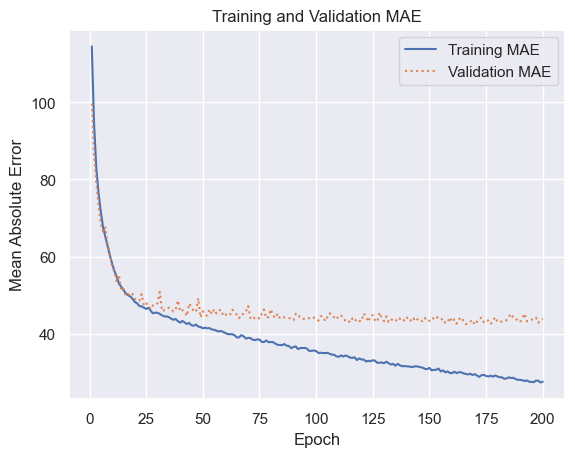

In [74]:
# Fit the model to the training data, specifying validation split, epochs, and batch size.
hist = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32)
# Set the style of the plots using Seaborn.
sns.set()
# Extract the training and validation Mean Absolute Error (MAE) from the training history.
err = hist.history['mae']
val_err = hist.history['val_mae']
# Define the number of epochs.
epochs = range(1, len(err) + 1)
# Plot the Training MAE and Validation MAE over epochs.
plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()
# Use the trained model to predict on the test data.
y_pred = model.predict(X_test_scaled)

Evaluate the model

In [76]:
# Calculate the Mean Absolute Error (MAE) between the true and predicted values.
mae_nn = mean_absolute_error(y_test, y_pred)
# Calculate the Root Mean Squared Error (RMSE) between the true and predicted values.
mse_nn = mean_squared_error(y_test, y_pred)
# Calculate the R-squared (R2) score, a measure of how well the model explains the variance in the data.
r2_nn = r2_score(y_test, y_pred)
# Print the calculated metrics.
print(f"Mean Absolute Error of NN: {mae_nn}")
print(f"Mean Squared Error: {mse_nn}")
print(f"R-squared of NN: {r2_nn}")
     

Mean Absolute Error of NN: 42.739464515577936
Mean Squared Error: 4707.799792268139
R-squared of NN: 0.851326744432718


In [62]:
# A super-fast baseline, just for context
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print({"LR_MAE": mae_lr, "LR_R2": r2_lr, "LR_MSE":mse_lr})

{'LR_MAE': 104.79577059911452, 'LR_R2': 0.3879974354720257, 'LR_MSE': 19379.312944744703}


In [63]:

import pandas as pd
results = pd.DataFrame([
    {'Model': 'Linear Regression', 'MAE': mae_lr, 'R2': r2_lr, "MSE":mse_lr},
    {'Model': 'Neural Net', 'MAE': mae_nn, 'R2': r2_nn, "MSE":mse_nn},
])
results

,Model,MAE,R2,MSE
0,Linear Regression,104.795771,0.387997,19379.312945
1,Neural Net,25.364293,0.943788,1779.967895
